In [1]:
import pandas as pd
from copy import deepcopy
import datetime
pd.options.display.max_rows = None
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.base import is_classifier, is_regressor
import multiprocessing
from sklearn.utils import resample
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
import pickle
import itertools
from scipy.stats import norm
import openml
import matplotlib.pyplot as plt
import matplotlib
import time
from threadpoolctl import threadpool_limits

In [17]:
'''
Function that downloads and stores the data from the OpenML-CC18 benchmark tasks.
'''
def download_openmlcc18():
  # Instructions to obtain OpenML API key: https://docs.openml.org/Python-guide/
  openml.config.apikey = 'YOURKEY' 
  openml.config.set_cache_directory('/root/openmlcache')
  benchmark_suite = openml.study.get_suite('OpenML-CC18') 
  for task_id in benchmark_suite.tasks:  
      task = openml.tasks.get_task(task_id)  
      print(task)
      features, targets = task.get_X_and_y()
      with open("/root/notebooks/OpenML-CC18/{}".format(task_id), "wb") as f:
        pickle.dump((features, targets), f)
        

In [3]:
'''
Function summarizing the downloaded OpenML-CC18 tasks.
'''
def summarize_openmlcc18():
  openmlcc18_summary = pd.DataFrame()

  # Instructions to obtain OpenML API key: https://docs.openml.org/Python-guide/
  openml.config.apikey = 'YOURKEY' 
  openml.config.set_cache_directory('/root/openmlcache')
  benchmark_suite = openml.study.get_suite('OpenML-CC18') 

  print("Loading tasks...\r")
  for task_id, dataset_id in zip(benchmark_suite.tasks, benchmark_suite.data):  
      with open("/root/notebooks/OpenML-CC18/{}".format(task_id), "rb") as f:
        features, targets = pickle.load(f)
        entry = {"task_id" : task_id, "dataset_id": dataset_id, 
                 "samples" : features.shape[0], "contexts"  : features.shape[1], "arms" : len(np.unique(targets))}
        openmlcc18_summary = openmlcc18_summary.append(entry, ignore_index=True)
  openmlcc18_summary = openmlcc18_summary.astype(int)
  openmlcc18_summary = openmlcc18_summary.set_index('task_id')
  openmlcc18_summary = openmlcc18_summary.sort_values(by='samples', ascending=False)
  
  return openmlcc18_summary


In [4]:
'''
Class creating a bandit dataset out of an OpenML-CC18 task.
'''
class OpenMLCC18_World:
  def __init__(self, task_id, reward_variance=0):
    self.task_id = task_id
    with open("/root/notebooks/OpenML-CC18/{}".format(task_id), "rb") as f:
      self.contexts, self.arms = pickle.load(f)
    
    if np.sum(np.isnan(self.contexts)) > 0: 
      self.contexts = SimpleImputer().fit_transform(self.contexts)
    self.arm_count = len(np.unique(self.arms))
    self.feature_count = self.contexts.shape[1]
    self.observation_count = self.contexts.shape[0]

    shuffle = np.argsort(np.random.random(size=self.observation_count))
    self.contexts = self.contexts[shuffle]
    self.arms = self.arms[shuffle]
    self.context_to_optimal_arm_dict = dict(zip([tuple(c) for c in self.contexts], self.arms))
    self.reward_variance = reward_variance

    self.observation_index = 0

  def reset(self):
    self.observation_index = 0

  def optimal_arm(self, feature_vector):
    return self.context_to_optimal_arm_dict[tuple(feature_vector)]

  def regret(self, feature_vector, arm_id):
    return int(arm_id != self.context_to_optimal_arm_dict[tuple(feature_vector)])

  def reward(self, feature_vector, arm_id):
    reward_mean = int(arm_id == self.context_to_optimal_arm_dict[tuple(feature_vector)])
    return reward_mean + np.random.normal(loc=0, scale=np.sqrt(self.reward_variance))

  def reward_mean_per_arm(self, feature_vector):
    reward_means = np.zeros(self.arm_count)
    reward_means[self.context_to_optimal_arm_dict[tuple(feature_vector)]] = 1
    return reward_means

  def get_deterministic_batch_of_contexts(self, batch_size):
    start = self.observation_index
    end = self.observation_index + batch_size
    if end <= self.observation_count:
      self.observation_index = end
      return self.contexts[start:end, :], self.arms[start:end]
    else:
      end = end % self.observation_count
      self.observation_index = end
      return np.vstack([self.contexts[start:, :], self.contexts[:end, :]]), \
             np.vstack([self.arms[start:], self.arms[:end]])
   
  def get_new_batch_of_contexts(self, batch_size):
    contexts = resample(self.contexts, n_samples=batch_size)
    return contexts
    
  def get_fully_labeled_data(self, batch_size):
    contexts, labels = resample(self.contexts, self.arms, n_samples=batch_size)
    return contexts, labels
    

In [5]:
'''
Function wrapping prediction of expected outcome for both classifiers and regressors.
'''
def predict(model, X):
  # TODO(Update to work with classification pipelines.)
  if is_classifier(model):
    if len(model.classes_) == 1:
      return np.ones(len(X)) * model.classes_[0]
    else:
      return model.predict_proba(X)[:, 1]
  else:
    return model.predict(X)
  raise ValueError
  

In [6]:
'''
Class simulating logging policy. 
'''
class LoggingPolicy:
  def __init__(self, batch_count, batch_size, 
               outcome_model=None, logging_policy='uniform_random', epsilon_multiplier=1,
               verbose=False):
    self.batch_count = batch_count
    self.batch_size = batch_size
    self.outcome_model = outcome_model
    self.logging_policy = logging_policy
    self.epsilon_multiplier = epsilon_multiplier
    self.verbose = verbose
    
    self.debug_string = "world: {}\nbatch_count: {}\nbatch_size: {}\nbandit: {} {} epsilon_multiplier={}" \
          .format(world.__class__.__name__, self.batch_count, self.batch_size, 
                  self.logging_policy, self.outcome_model, self.epsilon_multiplier)
    
  def run(self):
    with threadpool_limits(limits=1, user_api='blas'):
      self.X = []
      self.A = []
      self.Y = []
      self.P = []
      self.regret = []
      self.previous_P = []
      self.epsilon = []

      for batch_id in range(self.batch_count):
        if self.verbose:
          print("Progress: {}/{}...".format(batch_id + 1, self.batch_count), end='\r')
        
        X_test = world.get_new_batch_of_contexts(self.batch_size)

        outcome_models = []
        if self.logging_policy == 'uniform_random':
          epsilon = 1
          A_test = np.random.choice(range(world.arm_count), size=X_test.shape[0])
          P_test = np.ones(shape=X_test.shape[0]) * (1 / world.arm_count)

        elif self.logging_policy == 'contextual_epsilon_greedy':
          unique_arms, count_per_arm = np.unique(self.A, return_counts=True)
          if len(unique_arms) == world.arm_count and np.min(count_per_arm) >= 1:
            # Train the estimator and obtain predictions.
            Y_hat_test = np.zeros(shape=(X_test.shape[0], world.arm_count))
            for a in range(world.arm_count):
              indicator_a, = np.where(np.array(self.A) == a)
              Y_a = np.array(self.Y)[indicator_a]
              X_a = np.array(self.X)[indicator_a, :]
              model_a = deepcopy(self.outcome_model)
              # TODO(Update to work with classification pipelines.)
              if is_classifier(model_a):
                classes = np.unique(Y_a)
                if len(classes) == 1:
                  model_a.classes_ = deepcopy(classes)
                else:
                  model_a.fit(X=X_a, y=Y_a)
              else:
                model_a.fit(X=X_a, y=Y_a)
              outcome_models.append(model_a)
              Y_hat_test[:, a] = predict(model_a, X_test)

            # Compute epsilon = (number of observations + 1)^(-1/3)
            epsilon = self.epsilon_multiplier * (batch_id * self.batch_size + 1)**(-1/3)

            # Choose arms.
            A_test_random = np.random.choice(range(world.arm_count), size=X_test.shape[0])
            A_test_best = np.argmax(Y_hat_test, axis=1)
            test_coin_flip = np.random.random(size=X_test.shape[0]) >= epsilon
            A_test = A_test_best * test_coin_flip + A_test_random * (1 - test_coin_flip)
            P_test = (1 - epsilon + epsilon / world.arm_count) * (A_test == A_test_best) \
                   + (epsilon / world.arm_count) * (A_test != A_test_best)  

          else:
            # Not enough observations for contextual assignment; do uniform random instead.
            epsilon = 1
            A_test = np.random.choice(range(world.arm_count), size=X_test.shape[0])
            P_test = np.ones(shape=X_test.shape[0]) * (1 / world.arm_count)

        else:
          raise ValueError

        # Observe the outcomes.
        Y_test =  [world.reward(x, a) for x, a in zip(X_test, A_test)]

        # Store the observations.
        self.X += list(X_test)
        self.A += list(A_test)
        self.Y += list(Y_test)
        self.P += list(P_test)
        self.epsilon += [epsilon] * X_test.shape[0]

        # Store the self.regret.
        self.regret += [world.regret(x, a) for x, a in zip(X_test, A_test)]

        # Log propensities for previous observations.
        if len(outcome_models) == 0:
          previous_P = np.ones(len(self.A)) * (1 / world.arm_count)
        else:
          Y_hat = np.zeros(shape=(len(self.X), world.arm_count))
          for a, model_a in enumerate(outcome_models):
            Y_hat[:, a] = predict(model_a, self.X)
          A_best = np.argmax(Y_hat, axis=1)
          previous_P = (np.array(self.A) == A_best) * (1 - epsilon + epsilon / world.arm_count) \
                        + (np.array(self.A) != A_best) * (epsilon / world.arm_count)
        self.previous_P.append(previous_P)
    
    self.X = np.array(self.X)
    self.A = np.array(self.A)
    self.Y = np.array(self.Y)
    self.P = np.array(self.P)
    self.regret = np.array(self.regret)
    self.epsilon = np.array(self.epsilon)
    

In [7]:
'''
Function defining target policy. 
'''
class TargetPolicy:
  def __init__(self, policy_name, contextual_outcome_model=None, contextual_train_sample_size=None):
    
    self.arm_count = world.arm_count
    self.policy_name = policy_name
    self.non_contextual_assignment = None
    self.contextual_outcome_models = None
    
    self.debug_string = "{}".format(self.policy_name)
    if contextual_outcome_model is not None:
      self.debug_string += " {}".format(contextual_outcome_model)
    
    if 'non_contextual_constant' in self.policy_name:
      arm = int(self.policy_name.replace('non_contextual_constant_', ''))
      self.non_contextual_assignment = np.zeros(self.arm_count)
      self.non_contextual_assignment[arm] = 1

    elif self.policy_name == 'non_contextual_uniform_random':
      self.non_contextual_assignment = np.ones(self.arm_count) / self.arm_count
    
    elif self.policy_name == 'non_contextual_most_frequent':
      labels, frequency = np.unique(world.arms, return_counts=True)
      self.non_contextual_assignment = np.zeros(self.arm_count)
      self.non_contextual_assignment[np.argmax(frequency)] = 1

    elif self.policy_name == 'non_contextual_frequency_proportional':
      labels, frequency = np.unique(world.arms, return_counts=True)
      self.non_contextual_assignment = frequency / np.sum(frequency)

    elif 'contextual' in self.policy_name:
      contexts = world.get_new_batch_of_contexts(contextual_train_sample_size)
      arms = np.random.choice(range(self.arm_count), size=contexts.shape[0])
      rewards = [world.reward(x, a) for x, a in zip(contexts, arms)]
      self.contextual_outcome_models = []
      for a in range(self.arm_count):
        indicator_a, = np.where(np.array(arms) == a)
        Y_a = np.array(rewards)[indicator_a]
        X_a = np.array(contexts)[indicator_a, :]
        model_a = deepcopy(contextual_outcome_model)
        model_a.fit(X_a, Y_a)
        self.contextual_outcome_models.append(model_a)

    else:
      raise ValueError
      
  def pi(self, X):
    if 'non_contextual' in self.policy_name:
      return np.array([self.non_contextual_assignment] * len(X))
    else:
      Y_hat = np.zeros(shape=(X.shape[0], self.arm_count))
      contextual_assignment = np.zeros(shape=(X.shape[0], self.arm_count))
      for a in range(self.arm_count):
        if X.shape[0] == 1:
          Y_hat[:, a] = predict(self.contextual_outcome_models[a], X.reshape(1, -1))
        else:
          Y_hat[:, a] = predict(self.contextual_outcome_models[a], X)
      best_predicted_arm = np.argmax(Y_hat, axis=1)
      for a in range(self.arm_count):
        contextual_assignment[:, a] = (best_predicted_arm == a).astype(int)
      return contextual_assignment


In [8]:
'''
Class implementing all OPE estimators.
'''
class OPEEstimator:
  def __init__(self, bandit, 
               outcome_model, outcome_model_training, train_sample_size, 
               target_policy, verbose=False):
    
    self.X = bandit.X
    self.A = bandit.A
    self.Y = bandit.Y
    self.P = bandit.P
    self.previous_P = bandit.previous_P
    self.epsilon = bandit.epsilon
    self.batch_size = bandit.batch_size
    self.arm_count = world.arm_count
    
    self.truth = None
    self.dm = None
    self.ips = None
    self.dr = None
    self.adr = None
    self.cadr = None
    self.mrdr = None
    self.camrdr = None
    
    # Train the outcome models per arm and store the predictions.
    self.Q = np.zeros((len(self.X), world.arm_count))
    self.Q_MRDR = np.zeros((len(self.X), world.arm_count))
    self.Q_CAMRDR = np.zeros((len(self.X), world.arm_count))
    
    if outcome_model_training == 'sequential_sample_splitting':
      self.index_train = np.array([])
      self.index_eval = np.array(range(len(self.X)))
      
      # Do sequential sample splitting.
      with threadpool_limits(limits=1, user_api='blas'):
        for t in range(1, len(self.X)):
          if verbose:
            print("Sequential Splitting Progress: {}/{}...".format(t + 1, len(self.X)), end='\r')
          
          for a in range(world.arm_count):
            indicator_a, = np.where(np.array(self.A[0:t]) == a)
            if len(indicator_a) == 0:
              continue
            Y_a = np.array(self.Y[0:t])[indicator_a]
            X_a = np.array(self.X[0:t])[indicator_a, :]
            # Train unweighted outcome model.
            model_a = deepcopy(outcome_model)
            model_a.fit(X=X_a, y=Y_a)
            self.Q[t, a] = predict(model_a, self.X[t].reshape(1, -1)) 
            # Train MRDR-weighted outcome model.
            # Loss function: \sum_{i=1}^{N} w_i (y_i - \hat{Q}_{a_i}(x_i))^2, 
            #                w_i = g^*(a_i | x_i) * (1 - g_t(a_i | x_i)) / g_t(a_i | x_i)^2
            g_a = np.array(self.P[0:t])[indicator_a]
            g_star_a = target_policy.pi(np.array(self.X[0:t])[indicator_a])[:, a]
            w_a = np.ones_like(Y_a) if np.all(g_star_a == 0) else g_star_a * (1-g_a) / g_a**2
            mrdr_model_a = deepcopy(outcome_model)
            mrdr_model_a.fit(X=X_a, y=Y_a, sample_weight=w_a)
            self.Q_MRDR[:, a] = predict(mrdr_model_a, self.X[t].reshape(1, -1))
            w_a = np.ones_like(Y_a) if np.all(g_star_a == 0) else g_star_a / g_a
            camrdr_model_a = deepcopy(outcome_model)
            camrdr_model_a.fit(X=X_a, y=Y_a, sample_weight=w_a)
            self.Q_CAMRDR[:, a] = predict(camrdr_model_a, self.X[t].reshape(1, -1))
    
    elif outcome_model_training == 'cross_fitting':
      self.index_train = np.array([])
      self.index_eval = np.array(range(len(self.X)))
      
      # Do cross fitting.
      with threadpool_limits(limits=1, user_api='blas'):
        N = len(self.X)
        fold_number = 4
        fold_size = int(N / fold_number)
        for k in range(fold_number):
          valid = [before for before in range(0, k)] + [after for after in range(k+2, fold_number)]
          fold_train_index = [range(v * fold_size, (v+1) * fold_size) for v in valid]
          fold_train_index = list(itertools.chain.from_iterable(fold_train_index))
          fold_evaluation_index = list(range(k * fold_size, N)) if k == fold_number - 1 else \
                                  list(range(k * fold_size, (k+1) * fold_size))
          A_train = self.A[fold_train_index]
          X_train = self.X[fold_train_index]
          Y_train = self.Y[fold_train_index]
          P_train = self.P[fold_train_index]
          X_eval = self.X[fold_evaluation_index]
          for a in range(world.arm_count):
              indicator_a, = np.where(A_train == a)
              if len(indicator_a) == 0:
                continue
              Y_a = Y_train[indicator_a]
              X_a = X_train[indicator_a, :]
              # Train unweighted outcome model.
              model_a = deepcopy(outcome_model)
              model_a.fit(X=X_a, y=Y_a)
              self.Q[fold_evaluation_index, a] = predict(model_a, X_eval) 
              # Train MRDR-weighted outcome model.
              # Loss function: \sum_{i=1}^{N} w_i (y_i - \hat{Q}_{a_i}(x_i))^2, 
              #                w_i = g^*(a_i | x_i) * (1 - g_t(a_i | x_i)) / g_t(a_i | x_i)^2
              g_a = P_train[indicator_a]
              g_star_a = target_policy.pi(X_train[indicator_a])[:, a]
              w_a = np.ones_like(Y_a) if np.all(g_star_a == 0) else g_star_a * (1-g_a) / g_a**2
              mrdr_model_a = deepcopy(outcome_model)
              mrdr_model_a.fit(X=X_a, y=Y_a, sample_weight=w_a)
              self.Q_MRDR[fold_evaluation_index, a] = predict(mrdr_model_a, X_eval)
              w_a = np.ones_like(Y_a) if np.all(g_star_a == 0) else g_star_a / g_a
              camrdr_model_a = deepcopy(outcome_model)
              camrdr_model_a.fit(X=X_a, y=Y_a, sample_weight=w_a)
              self.Q_CAMRDR[fold_evaluation_index, a] = predict(camrdr_model_a, X_eval)

      
    else:
      raise ValueError
   
    # True labels.
    self.Y_true = np.array([world.reward_mean_per_arm(x) for x in self.X])
     
    self.g_star = target_policy.pi(self.X)        
    self.Q_star = np.sum(self.g_star * self.Q, axis=1)
    self.Q_MRDR_star = np.sum(self.g_star * self.Q_MRDR, axis=1)
    self.Q_CAMRDR_star = np.sum(self.g_star * self.Q_CAMRDR, axis=1)
    self.Q0_star = np.sum(self.g_star * self.Y_true, axis=1)
    
  def compute_estimators(self):
    self.compute_truth()
    self.compute_dm()
    self.compute_ips()
    self.compute_dr()
    self.compute_adr()
    self.compute_cadr() 
    self.compute_mrdr()
    self.compute_camrdr()  
   
   
  # V^* \frac{1}{N} \sum_{t=1}^N \sum_{a} g^*(a | x_i) E[Y | A=a, X=x_t]
  def compute_truth(self):
    D = self.Q0_star[self.index_eval]
    mean, _ = self.mean_and_variance(D)
    self.truth = mean, 0
    
  # V = \frac{1}{N} \sum_{t=1}^N \sum_{a} g^*(a | x_t) \hat{Q}(x_t, a)
  def compute_dm(self):
    D = []
    for t in self.index_eval:
      Dt = self.Q_star[t]
      D.append(Dt)
    D = np.array(D)
    self.dm = self.mean_and_variance(D)
  
  # V = \frac{1}{N} \sum_{t=1}^N \frac{g^*(a_t | x_t)}{g_t(a_t | x_t)} y_t
  def compute_ips(self):
    D = []
    for t in self.index_eval:
      Dt = (self.g_star[t, self.A[t]] / self.P[t]) * self.Y[t]
      D.append(Dt)
    D = np.array(D)
    self.ips = self.mean_and_variance(D)  
    
  # V = \frac{1}{N} \sum_{t=1}^N (\sum_{a} g^*(a | x_t) \hat{Q}(x_t, a) 
  #                              + \frac{g^*(a_t | x_t)}{g_t(a_t | x_t)} (y_t - hat{Q}(x_t, a_t)))
  def compute_dr(self):
    D = []
    for t in self.index_eval:
      Dt = self.Q_star[t] + (self.g_star[t, self.A[t]] / self.P[t]) * (self.Y[t] - self.Q[t, self.A[t]])
      D.append(Dt)
    D = np.array(D)
    self.dr = self.mean_and_variance(D)

  
  # V = \frac{1}{\sum_{t=1}^N w_t} \sum_{t=1}^N w_t ((\sum_{a} g^*(a | x_t) \hat{Q}(x_t, a) 
  #                                   + \frac{g^*(a_t | x_t)}{g_t(a_t | x_t)} (y_t - hat{Q}(x_t, a_t))))
  # w_t = \sqrt(g_t(a_t | x_t))
  def compute_adr(self):
    D = []
    w = []
    for t in self.index_eval:
      Dt = self.Q_star[t] + (self.g_star[t, self.A[t]] / self.P[t]) * (self.Y[t] - self.Q[t, self.A[t]])
      wt = np.sqrt(self.P[t])
      D.append(Dt)
      w.append(wt)
    D = np.array(D)
    w = np.array(w)
    self.adr = self.mean_and_variance(D, w)
    
  
  # D_t = \sum_{a} g^*(a | x_t) \hat{Q}_a(x_t) 
  #     + \frac{g^*(a_t | x_t)}{g_t(a_t | x_t)} (y_t - hat{Q}(x_t, a_t))
  # \frac{1}{N} \sum_{t=1}^N w_t D_t
  # w_i = \sqrt{\frac{1}{i-1} \sum_{j}^{i-1} \frac{g_t(a_j | x_j)}{g_t(a_i | x_i)} D_t^2 
  #             - \left(\frac{1}{i-1} \sum_{j}^{i-1} \frac{g_t(a_j | x_j)}{g_t(a_i | x_i)} D_t\right)^2}
  def compute_cadr(self):
    D = []
    sigma2 = []
    w = []

    for i in range(len(self.index_eval)):
      t = self.index_eval[i]
      Dt = self.Q_star[t] + (self.g_star[t, self.A[t]] / self.P[t]) * (self.Y[t] - self.Q[t, self.A[t]])

      if i == 0:
        sigma2t = 0
        wt = 0
      else:
        s_list = self.index_eval[0:i]
        gs_os = self.P[s_list]
        gt_os = self.previous_P[(t // self.batch_size)][s_list]
        D1_gt_os = self.Q_star[s_list] \
                 + (self.g_star[s_list, self.A[s_list]] / gt_os) * (self.Y[s_list] - self.Q[s_list, self.A[s_list]]) 

        psi1t = ((gt_os / gs_os) * (D1_gt_os**2))
        psi2t = ((gt_os / gs_os) * (D1_gt_os))

        sigma2t = np.mean(psi1t) - np.mean(psi2t)**2
        wt = 0 if sigma2t <= 0 else 1 / np.sqrt(sigma2t)

      sigma2.append(sigma2t)
      D.append(Dt)
      w.append(wt)

    D = np.array(D)
    w = np.array(w)
    sigma2 = np.array(sigma2)
    self.cadr = self.mean_and_variance(D, w)
    
  # V = \frac{1}{N} \sum_{t=1}^N (\sum_{a} g^*(a | x_t) \hat{Q_MRDR}(x_t, a) 
  #                              + \frac{g^*(a_t | x_t)}{g_t(a_t | x_t)} (y_t - hat{Q_MRDR}(x_t, a_t)))
  def compute_mrdr(self):
    D = []
    for t in self.index_eval:
      Dt = self.Q_MRDR_star[t] + (self.g_star[t, self.A[t]] / self.P[t]) * (self.Y[t] - self.Q_MRDR[t, self.A[t]])
      D.append(Dt)
    D = np.array(D)
    self.mrdr = self.mean_and_variance(D)
    
  
  # D_t = \sum_{a} g^*(a | x_t) \hat{Q_CAMRDR}_a(x_t) 
  #     + \frac{g^*(a_t | x_t)}{g_t(a_t | x_t)} (y_t - hat{Q_CAMRDR}(x_t, a_t))
  # \frac{1}{N} \sum_{t=1}^N w_t D_t
  # w_i = \sqrt{\frac{1}{i-1} \sum_{j}^{i-1} \frac{g_t(a_j | x_j)}{g_t(a_i | x_i)} D_t^2 
  #             - \left(\frac{1}{i-1} \sum_{j}^{i-1} \frac{g_t(a_j | x_j)}{g_t(a_i | x_i)} D_t\right)^2}
  def compute_camrdr(self):
    D = []
    sigma2 = []
    w = []

    for i in range(len(self.index_eval)):
      t = self.index_eval[i]
      Dt = self.Q_CAMRDR_star[t] + (self.g_star[t, self.A[t]] / self.P[t]) * (self.Y[t] - self.Q_CAMRDR[t, self.A[t]])

      if i == 0:
        sigma2t = 0
        wt = 0
      else:
        s_list = self.index_eval[0:i]
        gs_os = self.P[s_list]
        gt_os = self.previous_P[(t // self.batch_size)][s_list]
        D1_gt_os = self.Q_CAMRDR_star[s_list] \
                 + (self.g_star[s_list, self.A[s_list]] / gt_os) * (self.Y[s_list] - self.Q_CAMRDR[s_list, self.A[s_list]]) 

        psi1t = ((gt_os / gs_os) * (D1_gt_os**2))
        psi2t = ((gt_os / gs_os) * (D1_gt_os))

        sigma2t = np.mean(psi1t) - np.mean(psi2t)**2
        wt = 0 if sigma2t <= 0 else 1 / np.sqrt(sigma2t)

      sigma2.append(sigma2t)
      D.append(Dt)
      w.append(wt)

    D = np.array(D)
    w = np.array(w)
    sigma2 = np.array(sigma2)
    self.camrdr = self.mean_and_variance(D, w)
    
  def mean_and_variance(self, D, w=None):
    if w is None:
      w = np.ones_like(D)
    mean = D.dot(w) / np.sum(w)
    variance = (w**2).dot((D - mean)**2) / (np.sum(w))**2
    return mean, variance
  

In [9]:
'''
Class running many LoggingPolicy instances in parallel.
'''
class BanditSimulator:
  def __init__(self, bandit, simulation_count, seed=1704, verbose=False):
    
    self.bandit = bandit
    self.simulation_count = simulation_count
    self.seed = seed
    
    self.manager = multiprocessing.Manager()
    self.manager_bandit_list = self.manager.list()
    self.bandit_list = None
    self.regret_list = None
    
    self.verbose = verbose
    
    self.debug_string = self.bandit.debug_string \
                      + "\nsimulation_count: {}\nseed: {}".format(self.simulation_count, self.seed)
    
  def simulate(self):
    if self.seed is not None:
      np.random.seed(self.seed)
      
    t0 = time.time()
    processes = []
    for s in range(self.simulation_count):
      p = multiprocessing.Process(target=self.single_simulation, args=(s,))
      processes.append(p)
    [p.start() for p in processes]
    [p.join() for p in processes]
    [p.terminate() for p in processes]
    t1 = time.time()
    print("BanditSimulator.simulate() DONE ({}) ".format(t1-t0))
   
  def single_simulation(self, s):
    t0 = time.time()
    np.random.seed((s+1) * 1704)
    bandit_s = LoggingPolicy(batch_count=self.bandit.batch_count, batch_size=self.bandit.batch_size, 
                             logging_policy=self.bandit.logging_policy, 
                             outcome_model=deepcopy(self.bandit.outcome_model), 
                             epsilon_multiplier=self.bandit.epsilon_multiplier)
    bandit_s.run()
    self.manager_bandit_list.append(bandit_s)
    t1 = time.time()
    if self.verbose:
      print("\tBanditSimulator.single_simulation({}) DONE ({}) ".format(s, t1-t0))
    
  def aggregate(self):
    t0 = time.time()
    self.bandit_list = list(self.manager_bandit_list)
    self.manager.shutdown()
    self.regret_list = []
    for bandit in self.bandit_list:
      self.regret_list.append(bandit.regret)
    t1 = time.time()
    print("BanditSimulator.aggregate() DONE ({}) ".format(t1-t0))
    

In [10]:
'''
Class running many OPEEstimator instance in parallel with input 
a list of bandit data collected by different LoggingPolicy instances
and a list of outcome models tained by their matching OPEOutcomeModelTrainer instances. 
'''
class OPEEstimatorSimulator:
  def __init__(self,
               bandit_simulator, 
               outcome_model, outcome_model_training, train_sample_size, 
               target_policy, 
               verbose=False,
               seed=1704):
    
    self.bandit_simulator = bandit_simulator
    self.outcome_model = outcome_model
    self.outcome_model_training = outcome_model_training
    self.train_sample_size = train_sample_size
    self.target_policy = target_policy
    self.seed = seed
    self.verbose = verbose
    
    self.simulation_count = self.bandit_simulator.simulation_count
    
    self.manager = multiprocessing.Manager()
    self.manager_ope_list = self.manager.list([[]] * self.simulation_count)
    self.ope_list = None
    
  def simulate(self):
    if self.seed is not None:
      np.random.seed(self.seed)
    
    t0 = time.time()
    processes = []
    for s in range(self.simulation_count):
      p = multiprocessing.Process(target=self.single_simulation, args=(s,))
      processes.append(p)
    [p.start() for p in processes]
    [p.join() for p in processes]
    [p.terminate() for p in processes]
    t1 = time.time()
    print("OPEEstimatorSimulator.simulate() DONE ({}) ".format(t1-t0))
      
   
  def single_simulation(self, s):
    t0 = time.time()
    np.random.seed((s+1) * 1704)
    bandit = self.bandit_simulator.bandit_list[s]
    ope = OPEEstimator(
            bandit=bandit,
            outcome_model=self.outcome_model, outcome_model_training=self.outcome_model_training, 
            train_sample_size=self.train_sample_size,
            target_policy=self.target_policy)
    ope.compute_estimators()
    self.manager_ope_list[s] = ope
    t1 = time.time()
    if self.verbose:
      print("\tOPEEstimatorSimulator.single_simulation({}) DONE ({}) ".format(s, t1-t0))
    
  def aggregate(self):
    t0 = time.time()
    self.ope_list = [self.manager_ope_list[s] for s in range(self.simulation_count)]
    self.manager.shutdown()
    t1 = time.time()
    print("OPEEstimatorSimulator.aggregate() DONE ({}) ".format(t1-t0))
    

In [11]:
'''
Function reporting bias, RMSE, 95% CI coverage and CI radius
from a list of simulated OPE.
'''
def get_estimator_metrics(ope_simulator, target_policy_prefix,
                          estimator_list=['truth', 'dm', 'ips', 'dr', 'adr', 'cadr',
                                          'mrdr', 'camrdr']):
  simulation_count = ope_simulator.simulation_count
  all_estimator_results = np.zeros((len(estimator_list), ope_simulator.simulation_count, 2))
  
  for i, estimator_name in enumerate(estimator_list):
    for s, ope in enumerate(ope_simulator.ope_list):
      exec('all_estimator_results[i, s] = ope.{}'.format(estimator_name))
  
  coverage_95 = np.zeros((len(estimator_list), ope_simulator.simulation_count))
  for e in range(len(estimator_list)):
    coverage_95[e] = (all_estimator_results[e, :, 0] - 1.96 * np.sqrt(all_estimator_results[e, :, 1]) 
                      <= all_estimator_results[0, :, 0]).astype(int) \
                   * (all_estimator_results[e, :, 0] + 1.96 * np.sqrt(all_estimator_results[e, :, 1]) 
                      >= all_estimator_results[0, :, 0]).astype(int)
  if print_intermediate_plots:
    bar_plot(data=coverage_95[1:], metric='95% CI Coverage', labels=estimator_list[1:], truth=0.95)
  
  return_value = {target_policy_prefix + '_coverage_95_mean' : np.mean(coverage_95, axis=1),
                  target_policy_prefix + '_coverage_95_stderr' : np.sqrt(np.var(coverage_95, axis=1) / simulation_count),
                  }
  return return_value


In [12]:
'''
Estimator to estimator comparison w.r.t. 95% coverage.
'''
def visualize_coverage(ope_outcome_model, ope_outcome_model_training,
                       task_min_samples, task_max_contexts, simulation_count,
                       reward_variance, epsilon_multiplier, batch_count, batch_size):

  setup_string = 'REPRODUCE_OPE{}{}_tms{}_tmc{}_s{}_rv{}_em{}_bc{}_bs{}'.format(
    ope_outcome_model_training, ope_outcome_model,
    task_min_samples, task_max_contexts, simulation_count, 
    reward_variance, epsilon_multiplier, batch_count, batch_size)

  data = pd.read_pickle('{}_all_tasks_df_data'.format(setup_string))
  
  estimators = ['Truth', 'DM', 'IPW', 'DR', 'ADR', 'CADR', 'MRDR', 'CAMRDR']
  target_policies = ['linear', 'tree', 'arm0', 'arm1']
  target_policy_names = ['linear contextual\ntarget policy', 'tree contextual\ntarget policy',
                         'arm 0 non-contextual\ntarget policy', 'arm 1 non-contexual\ntarget policy']
  est_dict = dict(zip(estimators, range(len(estimators))))

  competitors = ['DM', 'IPW', 'DR', 'ADR', 'MRDR']
  main = 'CADR'

  fontsize = 16
  size = 3
  nrows = len(target_policies)
  ncols = len(competitors)
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size * (ncols+3.5), size * (nrows+1)))
  fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.5)

  for t, target_policy in enumerate(target_policies):
    mean = np.array(data['{}_coverage_95_mean'.format(target_policy)].to_list())
    stderr = np.array(data['{}_coverage_95_stderr'.format(target_policy)].to_list())

    for i2, e2 in enumerate([est_dict[main]]):
      for i1, e1 in enumerate([est_dict[c] for c in competitors]):
        ax = axs[t][i1]
        colors = []
        for i in range(len(mean[:, e1])):
          x = mean[i, e1]
          y = mean[i, e2]
          xerr = stderr[i, e1]
          yerr = stderr[i, e2]
          if np.abs(x - y) <= xerr + yerr:
            colors.append([0,0,0])
          elif x > y:
            colors.append([1,0,0])
          elif x < y:
            colors.append([0,0,1])
          else:
            raise ValueError
        colors = np.array(colors).astype(float)
        ax.scatter(x=mean[:, e1], y=mean[:, e2], zorder=3, c=colors, s=50, alpha=0.5)
        ax.errorbar(x=mean[:, e1], y=mean[:, e2], xerr=stderr[:, e1], yerr=stderr[:, e2], c='black', zorder=0, fmt='none')
        ax.set_xlabel('{} 95% CI Coverage'.format(estimators[e1]), fontsize=fontsize)
        ax.set_ylabel('{} 95% CI Coverage'.format(estimators[e2]), fontsize=fontsize)
        ax.tick_params(axis='both', which='major', labelsize=fontsize-4)
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])
        ax.axhline(y=0.95, linestyle='--', color='black')
        ax.axvline(x=0.95, linestyle='--', color='black')
        ax.axline(xy1=(0, 0), xy2=(10, 10), linestyle='-', color='black', alpha=0.3) 
        ax.set_title("{}".format(target_policy_names[t]), fontsize=fontsize)
  plt.savefig('Figures/coverage_e{}_rv{}_{}.jpg'.format(str(epsilon_multiplier).replace('.', ''), reward_variance,
                                                       main))
  plt.show()

In [13]:
'''
Function plotting a metric's mean and confidence interval
for a list of OPE estimators.
'''
def bar_plot(data, metric, labels, truth=None):
  mean_metric = np.mean(data, axis=1)
  stderr_metric = np.sqrt(np.var(data, axis=1) / data.shape[1])
  
  print('\n{}'.format(metric))
  for i, label in enumerate(labels):
    print('{}: {} ({})'.format(label.upper(), mean_metric[i], stderr_metric[i]))
    
  cmap = matplotlib.cm.get_cmap('tab10')
  plt.bar(x=range(len(data)), color=cmap.colors, height=mean_metric, yerr=stderr_metric)
  plt.xticks(range(len(data)), [l.upper() for l in labels], rotation=90)
  if truth is not None:
    plt.axhline(y=truth, color='black', linestyle='--')
  plt.ylabel(metric)
  plt.show()
  

In [ ]:
%%time 

'''
Run selected task simulation.
'''

task_min_samples = 0
task_max_contexts = 100
simulation_count = 64

reward_variance = 1
epsilon_multiplier = 0.01
batch_count = 100
batch_size = 100

ope_outcome_model = LinearRegression()
ope_outcome_model_training = 'cross_fitting'

print_intermediate_plots = False

setup_string = 'REPRODUCE_OPE{}{}_tms{}_tmc{}_s{}_rv{}_em{}_bc{}_bs{}'.format(
  ope_outcome_model_training, ope_outcome_model,
  task_min_samples, task_max_contexts, simulation_count, 
  reward_variance, epsilon_multiplier, batch_count, batch_size)

# Select the tasks.
all_tasks_summary_df = summarize_openmlcc18()
selected_tasks_summary_df = all_tasks_summary_df[(all_tasks_summary_df['samples'] >= task_min_samples) 
                                                 & (all_tasks_summary_df['contexts'] <= task_max_contexts)]
selected_tasks_summary_df.to_pickle('{}_task_summary_df'.format(setup_string))

# Run simulation.
all_tasks_df_data =  pd.DataFrame()

print("Selected {} tasks.\n".format(len(selected_tasks_summary_df.index)))

world = None

for j, task_id in enumerate(selected_tasks_summary_df.index):
  t0 = time.time()
  
  print('\n======================================== task_id: {} ({}/{}) ========================================'
        .format(task_id, j+1, len(selected_tasks_summary_df.index)))
  print(selected_tasks_summary_df.loc[task_id][['arms', 'contexts', 'samples']])
  print()
  
  # Define world.
  world=OpenMLCC18_World(task_id=task_id, reward_variance=reward_variance) 
                         
  # Train bandits.
  bandit_simulator = BanditSimulator(
    bandit=LoggingPolicy(batch_count=batch_count, batch_size=batch_size, 
                         logging_policy='contextual_epsilon_greedy', 
                         outcome_model=DecisionTreeRegressor(), 
                         epsilon_multiplier=epsilon_multiplier), 
                         simulation_count=simulation_count, seed=1704)

  bandit_simulator.simulate()
  bandit_simulator.aggregate()
  
  if print_intermediate_plots:
    # Print bandit regret.
    horizon = len(bandit_simulator.bandit_list[0].A)
    uniform_regret_list = []
    for s in range(4):
      uniform_X = world.get_new_batch_of_contexts(horizon)
      uniform_A = np.random.choice(range(world.arm_count), size=horizon)
      uniform_regret_list.append([world.regret(x, a) for x, a in zip(uniform_X, uniform_A)])

    uniform_regrets = np.mean(np.array(uniform_regret_list), axis=0)
    plt.plot(np.cumsum(uniform_regrets), linewidth=2, color='black', linestyle='--', label='Uniform Random')  
    regrets = [np.mean(bandit_simulator.regret_list, axis=0)]
    for r in zip(regrets):
      plt.plot(np.cumsum(r), linewidth=2)
    plt.title("Multi-Class Classification Environment {} (Reward Variance {})\nTree ".format(task_id, reward_variance) 
              + r"$\epsilon$" + "-Greedy {} Bandit: ".format(bandit_simulator.bandit.outcome_model) 
              + r"$\epsilon_0 = {}$".format(epsilon_multiplier))
    plt.ylabel("Cumulative Regret")
    plt.xlabel("t")
    plt.show()
  
  
  # Run OPE for various target policies.
  all_target_policies_dict = dict()
  
  linear = TargetPolicy(
    policy_name='contextual', contextual_outcome_model=LinearRegression(),
    contextual_train_sample_size=len(bandit_simulator.bandit_list[0].X))

  tree = TargetPolicy(
    policy_name='contextual', contextual_outcome_model=DecisionTreeRegressor(),
    contextual_train_sample_size=len(bandit_simulator.bandit_list[0].X))

  arm0 = TargetPolicy(
    policy_name='non_contextual_constant_0')

  arm1 = TargetPolicy(
    policy_name='non_contextual_constant_1')

  for target_policy, name in zip([linear, tree, arm0, arm1], ['linear', 'tree', 'arm0', 'arm1']):
    if print_intermediate_plots:
      print('-------------------------- {} target policy --------------------------\n'.format(name))
    
    ope_simulator = OPEEstimatorSimulator(
      bandit_simulator=bandit_simulator, 
      outcome_model=LinearRegression(), outcome_model_training='cross_fitting', train_sample_size=None,
      target_policy=target_policy)
    ope_simulator.simulate()
    ope_simulator.aggregate()
    
    this_target_policy_dict = get_estimator_metrics(ope_simulator, target_policy_prefix=name)
    all_target_policies_dict = dict(list(all_target_policies_dict.items()) 
                                    + list(this_target_policy_dict.items()))
  
  # Store results.
  this_task_df_data = pd.DataFrame()
  this_task_df_data = this_task_df_data.append(all_target_policies_dict, ignore_index=True)
  this_task_df_data['task_id'] = task_id
  all_tasks_df_data = pd.concat([all_tasks_df_data, this_task_df_data], ignore_index=True)
  all_tasks_df_data.to_pickle('{}_all_tasks_df_data'.format(setup_string))
  
  if print_intermediate_plots:
    visualize_coverage(ope_outcome_model, ope_outcome_model_training,
                       task_min_samples, task_max_contexts, simulation_count,
                       reward_variance, epsilon_multiplier, batch_count, batch_size)
  
  t1 = time.time()
  print('task_id: {} DONE ({})'.format(task_id, t1-t0))
  

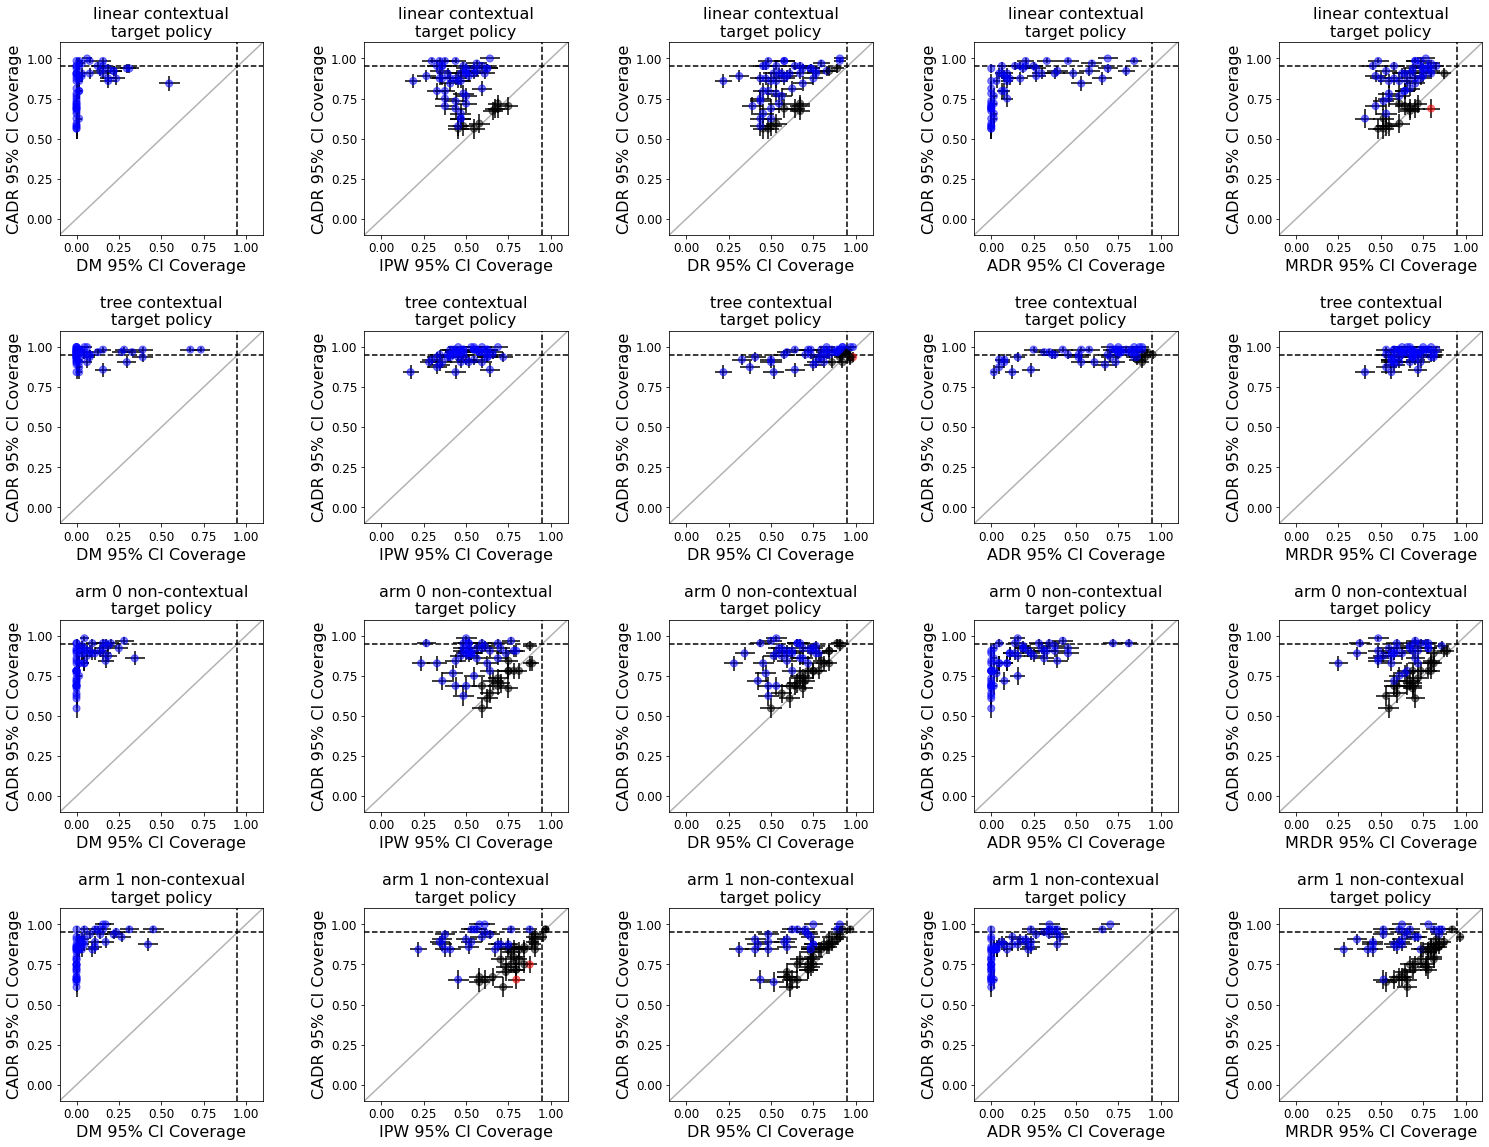

In [18]:
visualize_coverage(ope_outcome_model, ope_outcome_model_training,
                   task_min_samples, task_max_contexts, simulation_count,
                   reward_variance, epsilon_multiplier, batch_count, batch_size)